## 房價預測(回歸)

In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')

載入scikit-learn的boston housing [dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

In [4]:
# load boston_dataset
boston_dataset = load_boston()

載入後可以看到這個資料集像json格式，可以接著用一下程式碼看資料集的keys:
- data： 每個房子的資訊
- target： 每個房子的價格
- feature_names： 每個房子的特徵
- DESCR： 這個資料集的描述

In [5]:
# 取得每個特徵描述
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

將資料轉換成pd.DataFrame格式。目標輸出是MEDIV，剩下的就是特徵即為輸入特徵。

In [6]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 資料前處理
進一步處理之前先確認是否有缺失值：

In [7]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## 資料探索
接下來用簡單的資料視覺來看一下細部資料之間的關係。
MEDIV房價變數的分佈大致呈鐘型常態分佈：

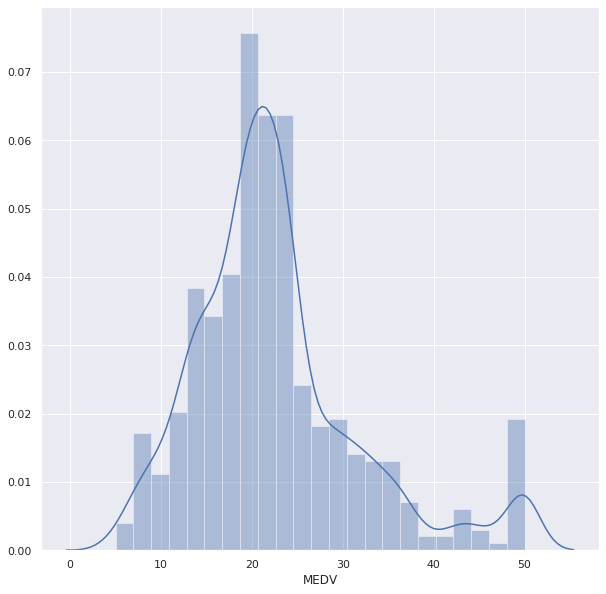

In [8]:
# 用seaborn一次把圖表的美化格式設定好，這裡是只有先設定圖表長寬
sns.set(rc={'figure.figsize':(10,10)})
# 使用的資料是房價MEDIV
sns.distplot(boston['MEDV'])
plt.show()

接下來我們可以看每個變數之間的關係，透過相關係數去觀察有哪些特徵變數和目標變數有較高的相關性等：

1. 跟MEDV（房價）高度相關的是LSTAT（中低收入戶佔當地居住人口的比例）和RM（房子有幾間房間）這兩個變數。
2. 此外也看到DIS（到波士頓商業中心的距離）和AGE（屋齡），INDUS（非零售業土地使用比例）和ZN（居住使用土地比例）這兩組變數有多元共線性問題，所以未來如果要做其他模型，避免同時使用這兩組中的變數。

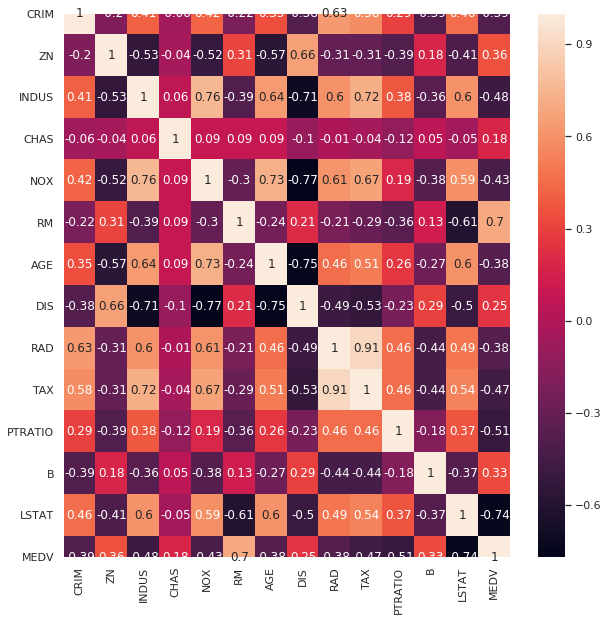

In [9]:
correlation_matrix = boston.corr().round(2)
# annot = True 讓我們可以把數字標進每個格子裡
sns.heatmap(data=correlation_matrix, annot = True)

可以用LSTAT和RM來做出預測MEDV的模型。再次把這兩個變數跟房價變數的關係畫出來，可以看到兩者和房價變數都接近線性關係：

- LSTAT和MEDV是負向關係
- RM和MEDV正向關係

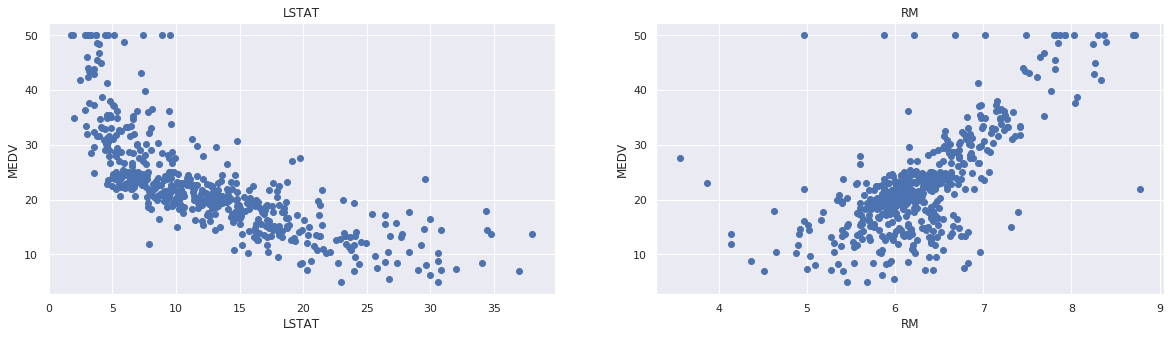

In [10]:
# 設定整張圖的長寬
plt.figure(figsize=(20, 5))
features = ['LSTAT', 'RM']
target = boston['MEDV']
for i, col in enumerate(features):
 # 排版1 row, 2 columns, nth plot：在jupyter notebook上兩張並排 
 plt.subplot(1, len(features) , i+1)
 # add data column into plot
 x = boston[col]
 y = target
 plt.scatter(x, y, marker='o')
 plt.title(col)
 plt.xlabel(col)
 plt.ylabel('MEDV')

## 切割訓練資料

In [11]:
from sklearn.model_selection import train_test_split
X  = boston.drop(['MEDV'],axis=1).values
y = boston[['MEDV']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('Training data shape:',X_train.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (455, 13)
Testing data shape: (51, 13)


## XGBoost(回歸器)
Boosting 則是希望能夠由後面生成的樹，來修正前面樹學的不好的地方。

Parameters:
- n_estimators: 總共迭代的次數，即決策樹的個數。預設值為100。
- max_depth: 樹的最大深度，默認值為6。
- booster: gbtree 樹模型(預設) / gbliner 線性模型
- learning_rate: 學習速率，預設0.3。
- gamma: 懲罰項係數，指定節點分裂所需的最小損失函數下降值。

Attributes:
- feature_importances_: 查詢模型特徵的重要程度。

Methods:
- fit: 放入X、y進行模型擬合。
- predict: 預測並回傳預測類別。
- score: 預測成功的比例。
- predict_proba: 預測每個類別的機率值。

In [17]:
import xgboost as xgb

# 建立xgbrModel模型
xgbrModel=xgb.XGBRegressor(n_estimators=100)
# 使用訓練資料訓練模型
xgbrModel.fit(X_train,y_train)

[10:45:14] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=100000)

In [50]:
print("Score: ",xgbrModel.score(X_train,y_train))

Score:  0.9734023592180522


### 模型評估
scikit-learn 決策樹迴歸模型的score函式是R2 score，可作為模型評估依據，其數值越接近於1代表模型越佳。
除了R2 score還有其他許多回歸模型的評估方法，例如： MSE、MAE、RMSE。

In [53]:
from sklearn import metrics
# 使用訓練資料預測
y_pred=xgbrModel.predict(X_train)
print("訓練集")
print('R2 score: ', xgbrModel.score(X_train,y_train))
mse = metrics.mean_squared_error(y_train, y_pred)
print('MSE score: ', mse)

# 使用測試資料預測
y_pred=xgbrModel.predict(X_test)
print("測試集")
print('R2 score: ', xgbrModel.score(X_test,y_test))
mse = metrics.mean_squared_error(y_test, y_pred)
print('MSE score: ', mse)

訓練集
R2 score:  0.9734023592180522
MSE score:  2.304005507957771
測試集
R2 score:  0.8961144427801024
MSE score:  6.486013485859004


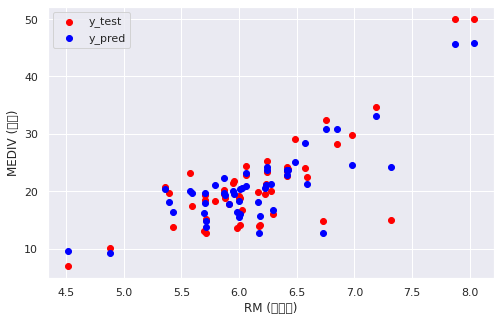

In [57]:
# plotting the y_test vs y_pred
plt.figure(figsize=(8,5))
plt.scatter(X_test[:,5], y_test, color='red', label='y_test')
plt.scatter(X_test[:,5], y_pred, color='blue', label='y_pred')
plt.xlabel('RM (房間數)')
plt.ylabel('MEDIV (房價)')
plt.legend(loc='upper left')
plt.show()